In [2]:
import json
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import pandas as pd
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [3]:
class WSIEmbeddingsDataset(Dataset):
    def __init__(self, base_dir="cases"):
        self.metadata = []
        self.missing_resolution_count = 0
        self.missing_embedding_DINO_count = 0
        self.missing_embedding_resnet_count = 0
        self.missing_survival_data_count = 0

        self.slide_stats_df = pd.read_csv(f"{base_dir}/slide_statistics.csv")
        case_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

        if "GENERAL_METADATA" in case_dirs:
            case_dirs.remove("GENERAL_METADATA")

        for case_id in case_dirs:
            case_dir = os.path.join(base_dir, case_id)
            metadata_path = os.path.join(case_dir, "aggregated_data", f'{case_id}_data.json')

            if not os.path.exists(metadata_path):
                print(f"No metadata found for case {case_id}, skipping...")
                continue
            
            with open(metadata_path, 'r') as f:
                case_metadata = json.load(f)

            if case_metadata["biospecimen"]["has_data"] == False or \
                case_metadata["clinical"]["has_data"] == False or \
                case_metadata["methylation"]["has_data"] == False:
                continue
            
            for sample in case_metadata["biospecimen"]["biospecimen_data"]:
                if sample["sample_type"] == "Primary Tumor":
                    for slide in sample["slides"]:
                        slide_barcode = slide["slide_barcode"]
                        
                        if slide["resolution_level"] <= 2:
                            self.missing_resolution_count += 1
                            print(f"Skipping slide {slide_barcode} from case {case_id} due to insufficient or missing resolution.")
                            continue
                        
                        death_event_occurred = 1
                        survival_time = case_metadata["clinical"]["clinical_patient_data"].get("days_to_death")
                        
                        if survival_time is None:
                            survival_time = case_metadata["clinical"]["clinical_patient_data"].get("days_to_last_followup")
                            death_event_occurred = 0

                        if survival_time is None:
                            self.missing_survival_data_count += 1
                            print(f"Skipping slide {slide_barcode} from case {case_id} due to missing survival data.")
                            continue

                        if "embedding_vit_DINO" not in slide or slide["embedding_vit_DINO"] is None:
                            self.missing_embedding_DINO_count += 1
                            print(f"Missing DINO embedding for slide {slide_barcode} from case {case_id}.")
                            continue

                        if "embedding_resnet50" not in slide or slide["embedding_resnet50"] is None:
                            self.missing_embedding_resnet_count += 1
                            print(f"Missing resnet embedding for slide {slide_barcode} from case {case_id}.")
                            continue

                        self.metadata.append({
                            "case_id": case_id,
                            "slide_barcode": slide_barcode,
                            "embedding_vit_DINO": slide["embedding_vit_DINO"],
                            "embedding_resnet50": slide["embedding_resnet50"],
                            "survival_time": float(survival_time),
                            "death_event_occurred": death_event_occurred
                        })

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        item = self.metadata[index]
        embedding_tensor_vit_DINO = torch.tensor(item["embedding_vit_DINO"], dtype=torch.float32)
        embedding_tensor_resnet50 = torch.tensor(item["embedding_resnet50"], dtype=torch.float32)
        survival_time = item["survival_time"]
        death_event_occurred = item["death_event_occurred"]
        return (embedding_tensor_vit_DINO, embedding_tensor_resnet50), (survival_time, death_event_occurred)

In [4]:
dataset = WSIEmbeddingsDataset(base_dir="cases")
all_data_loader = DataLoader(dataset)

Skipping slide TCGA-A6-5667-01A-01-BS1 from case 28d03569-8717-40da-8989-70baf2b18f9f due to insufficient or missing resolution.
Skipping slide TCGA-AA-3488-01A-01-BS1 from case 6e9e0c2f-2ddb-40f1-8e8c-618119e62ec1 due to insufficient or missing resolution.
Skipping slide TCGA-AA-3556-01A-01-TS1 from case fd16b634-2e04-44a3-862d-fb03cd73c057 due to insufficient or missing resolution.
Skipping slide TCGA-CK-4952-01A-01-BS1 from case 5342e2e8-1465-4f7b-9450-ef27280f80c7 due to insufficient or missing resolution.
Missing DINO embedding for slide TCGA-AA-3678-01A-01-BS1 from case c616f95f-4ea1-4019-8c17-041878085c88.
Skipping slide TCGA-AA-3521-01A-01-BS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AA-3521-01A-01-TS1 from case ad440651-a2de-4bb1-90da-1e5e8975ab59 due to missing survival data.
Skipping slide TCGA-AY-4070-01A-01-BS1 from case 6baf61b6-ae5b-42f0-adc9-0d26fda231f7 due to insufficient or missing resolution.
Skipping slide TCG

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from lifelines import CoxPHFitter
from SurvivalEVAL.Evaluator import LifelinesEvaluator

cph_resnet = CoxPHFitter(penalizer=0.01)
cph_DINO = CoxPHFitter(penalizer=0.01)

resnet_features_list = []
DINO_features_list = []
survival_times = []
death_event_occurred = []

for (DINO_embeddings, resnet_embeddings), (survival_time, death_value) in all_data_loader:
    resnet_features_list.append(resnet_embeddings.numpy())  
    DINO_features_list.append(DINO_embeddings.numpy())
    survival_times.extend(survival_time.tolist())
    death_event_occurred.extend(death_value.tolist())

resnet_features_df = pd.DataFrame([item for sublist in resnet_features_list for item in sublist], 
                                  columns=[f"resnet_feature_{i}" for i in range(resnet_features_list[0].shape[1])])
DINO_features_df = pd.DataFrame([item for sublist in DINO_features_list for item in sublist], 
                                columns=[f"DINO_feature_{i}" for i in range(DINO_features_list[0].shape[1])])

all_features_resnet = pd.concat([resnet_features_df], axis=1)
all_features_DINO = pd.concat([DINO_features_df], axis=1)

all_features_resnet['survival_time'] = survival_times
all_features_resnet['death_event_occurred'] = death_event_occurred

all_features_DINO['survival_time'] = survival_times
all_features_DINO['death_event_occurred'] = death_event_occurred

X_resnet = all_features_resnet.iloc[:, :-2]
y_resnet = all_features_resnet.iloc[:, -2:]

X_DINO = all_features_DINO.iloc[:, :-2]
y_DINO = all_features_DINO.iloc[:, -2:]

selector_resnet = VarianceThreshold(threshold=0.01)
selector_DINO = VarianceThreshold(threshold=0.01)

X_resnet_high_variance = selector_resnet.fit_transform(X_resnet)
X_DINO_high_variance = selector_DINO.fit_transform(X_DINO)

X_resnet_high_variance_df = pd.DataFrame(X_resnet_high_variance, columns=X_resnet.columns[selector_resnet.get_support()])
X_DINO_high_variance_df = pd.DataFrame(X_DINO_high_variance, columns=X_DINO.columns[selector_DINO.get_support()])

combined_resnet_df_cleaned = pd.concat([X_resnet_high_variance_df, y_resnet], axis=1)
combined_DINO_df_cleaned = pd.concat([X_DINO_high_variance_df, y_DINO], axis=1)

cph_resnet.fit(combined_resnet_df_cleaned, duration_col='survival_time', event_col='death_event_occurred')
print("Summary for ResNet Embedding:")
cph_resnet.print_summary()

cph_DINO.fit(combined_DINO_df_cleaned, duration_col='survival_time', event_col='death_event_occurred')
print("Summary for DINO Embedding:")
cph_DINO.print_summary()

Summary for ResNet Embedding:


<lifelines.CoxPHFitter: fitted with 847 total observations, 751 right-censored observations>
             duration col = 'survival_time'
                event col = 'death_event_occurred'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 847
number of events observed = 96
   partial log-likelihood = -414.07
         time fit was run = 2025-02-19 19:57:24 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
resnet_feature_6    -0.30      0.74      0.65           -1.57            0.97                0.21                2.64
resnet_feature_16    2.54     12.63      2.24           -1.85            6.92                0.16             1009.63
resnet_feature_23    1.33      3.78      1.23           -1.07            3.74                0.34               41.96
resnet_feature_41    0.15      1.16      0.62           -1.07            1.37                0.34                3.94
resnet_feature_71    1.85      6.33      1.88           -1.85            5.54                0.16              254.21
resnet_feature_76   -0.78      0.46      1.95           -4.60            3.03                0.01               20.72
resnet_feature_78    0.39      1.48      1.43           -2.40            3.19                0.09               24.30
resnet_feature_83   -1.28      0.28      1.41           -4.04            1.49                0.02                4.43
resnet_feature_94    0.56      1.76      0.49           -0.40            1.53                0.67                4.60
resnet_feature_97    0.45      1.57      0.41           -0.36            1.26                0.70                3.52
resnet_feature_99   -1.19      0.30      2.31           -5.73            3.34                0.00               28.14
resnet_feature_104   0.93      2.53      2.06           -3.10            4.96                0.04              142.11
resnet_feature_113   0.25      1.29      0.52           -0.76            1.27                0.47                3.55
resnet_feature_137   1.07      2.93      1.07           -1.02            3.17                0.36               23.72
resnet_feature_144  -1.39      0.25      1.58           -4.49            1.70                0.01                5.45
resnet_feature_152   0.23      1.26      0.44           -0.63            1.09                0.53                2.98
resnet_feature_175   1.65      5.23      2.14           -2.54            5.85                0.08              347.44
resnet_feature_178  -0.55      0.58      1.91           -4.30            3.19                0.01               24.35
resnet_feature_189   0.30      1.35      1.76           -3.16            3.76                0.04               42.82
resnet_feature_193   0.51      1.66      1.41           -2.26            3.27                0.10               26.32
resnet_feature_198  -0.35      0.70      1.23           -2.76            2.05                0.06                7.77
resnet_feature_209  -0.88      0.42      1.27           -3.37            1.61                0.03                5.03
resnet_feature_211  -1.75      0.17      2.47           -6.59            3.09                0.00               21.87
resnet_feature_226   1.38      3.97      2.41           -3.35            6.10                0.04              447.93
resnet_feature_234  -3.86      0.02      2.64           -9.04            1.32                0.00                3.73
resnet_feature_239  -0.27      0.76      1.01           -2.24            1.70                0.11                5.48
resnet_feature_241   0.66      1.94      1.19           -1.67            3.00                0.19               19.99
resnet_feature_248  -0.79      0.45      1.50           -3.73            2.15                0.02                8.55
resnet_feature_

Summary for DINO Embedding:


<lifelines.CoxPHFitter: fitted with 847 total observations, 751 right-censored observations>
             duration col = 'survival_time'
                event col = 'death_event_occurred'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 847
number of events observed = 96
   partial log-likelihood = -402.63
         time fit was run = 2025-02-19 19:57:25 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
DINO_feature_0   -0.00      1.00      0.41           -0.82            0.81                0.44                2.24
DINO_feature_1   -0.02      0.98      0.25           -0.52            0.47                0.60                1.61
DINO_feature_2    0.38      1.46      0.64           -0.88            1.63                0.42                5.12
DINO_feature_3    1.63      5.10      2.25           -2.79            6.04                0.06              421.89
DINO_feature_4   -0.09      0.92      1.09           -2.22            2.05                0.11                7.73
DINO_feature_5    0.04      1.04      0.26           -0.46            0.54                0.63                1.72
DINO_feature_6   -0.10      0.90      0.46           -1.00            0.80                0.37                2.22
DINO_feature_7    0.03      1.03      0.16           -0.28            0.34                0.76                1.40
DINO_feature_8   -0.02      0.98      0.30           -0.61            0.56                0.54                1.76
DINO_feature_9    0.08      1.08      0.45           -0.81            0.96                0.45                2.62
DINO_feature_10  -0.02      0.98      0.20           -0.41            0.38                0.66                1.46
DINO_feature_11  -0.25      0.78      0.82           -1.86            1.36                0.16                3.91
DINO_feature_12  -0.13      0.88      0.30           -0.71            0.46                0.49                1.58
DINO_feature_13   0.37      1.44      1.21           -2.01            2.74                0.13               15.56
DINO_feature_14   0.38      1.46      1.49           -2.54            3.30                0.08               27.05
DINO_feature_15  -0.22      0.80      0.45           -1.09            0.65                0.34                1.92
DINO_feature_16   0.09      1.09      0.38           -0.65            0.83                0.52                2.29
DINO_feature_17   0.21      1.23      0.23           -0.25            0.67                0.78                1.95
DINO_feature_18   0.13      1.14      0.27           -0.40            0.67                0.67                1.95
DINO_feature_19   0.01      1.01      0.25           -0.48            0.49                0.62                1.64
DINO_feature_20  -0.05      0.95      0.63           -1.29            1.19                0.27                3.30
DINO_feature_21   0.06      1.07      0.29           -0.51            0.64                0.60                1.89
DINO_feature_22  -0.04      0.96      0.34           -0.71            0.63                0.49                1.87
DINO_feature_23  -0.27      0.76      0.82           -1.88            1.33                0.15                3.78
DINO_feature_24   0.04      1.04      0.57           -1.07            1.15                0.34                3.15
DINO_feature_25  -0.18      0.83      0.28           -0.72            0.36                0.48                1.43
DINO_feature_26   0.24      1.28      0.64           -1.00            1.49                0.37                4.44
DINO_feature_27   0.03      1.03      0.18           -0.32            0.38                0.72                1.46
DINO_feature_28   0.21      1.23      0.78           -1.32            1.73                0.27           

<Axes: xlabel='timeline'>

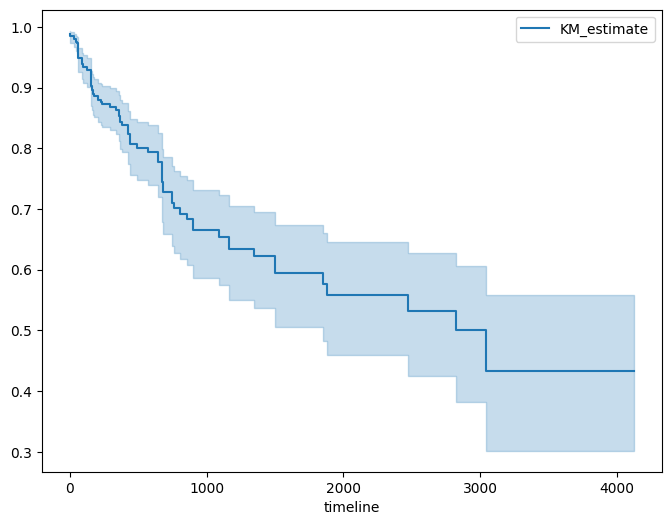

In [5]:
from lifelines import KaplanMeierFitter
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from SurvivalEVAL.Evaluator import LifelinesEvaluator

survival_times = []
death_event_occurred = []

for embedding_tensor, (survival_time, death_value) in all_data_loader:
    survival_times.extend(survival_time.tolist())
    death_event_occurred.extend(death_value.tolist())

survival_times = pd.Series(survival_times)
death_event_occurred = pd.Series(death_event_occurred)

kmf = KaplanMeierFitter()
kmf.fit(survival_times, event_observed=death_event_occurred)

plt.figure(figsize=(8, 6))
kmf.plot_survival_function()

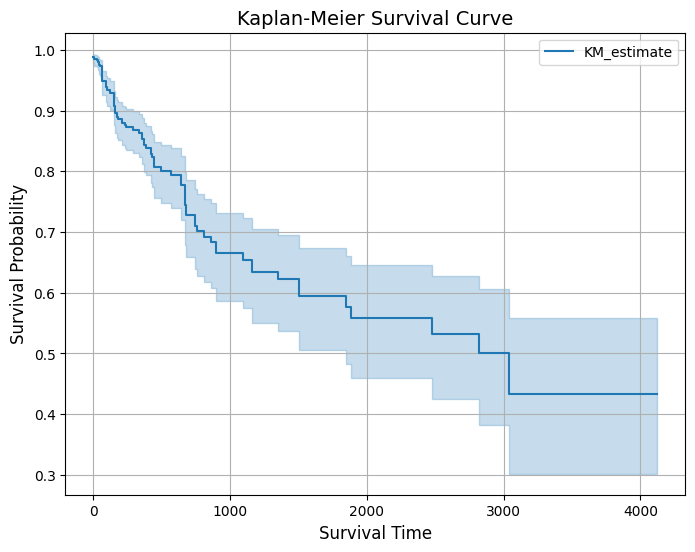

In [6]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

kmf = KaplanMeierFitter()
kmf.fit(survival_times, event_observed=death_event_occurred)

plt.figure(figsize=(8, 6))
kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve", fontsize=14)
plt.xlabel("Survival Time", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True)

plt.show()